In [2]:
library(Seurat)
library(SeuratDisk)
library(dplyr)
library(cowplot)
library(ggplot2)
library(ggpubr)
library(stringr)

library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)

In [3]:
setwd("/home/lhc/script/ARDS/neutrophilic_asthma/metadata")

In [4]:
load('saved_Rdata/labeled_ding_harmony_combined_final_0314.Rdata')
load('saved_Rdata/labeled_neutrophil_harmony_combined_final_0314.Rdata')

# GSEA

In [5]:
Idents(labeled_neutrophil_merged_data) <- labeled_neutrophil_merged_data@meta.data$on_interest
on_interest_markers <- FindMarkers(labeled_neutrophil_merged_data, ident.1 = 1, min.pct = 0.25)
head(on_interest_markers, n = 5)

p_val avg_log2FC pct.1 pct.2 p_val_adj
RPL22 0     1.969540   0.497 0.037 0        
C1QA  0     1.541102   0.337 0.015 0        
C1QB  0     1.687372   0.382 0.018 0        
RPL11 0     2.478641   0.757 0.166 0        
RPS8  0     1.831107   0.562 0.142 0

In [6]:
DEG <- on_interest_markers
geneList=DEG$avg_log2FC
names(geneList)= row.names(DEG)
geneList=sort(geneList,decreasing = T)
geneList %>% head()

HBB     HBA2     HBA1     APOE    RPS12     TFF3 
4.083208 3.987692 3.949838 3.088702 3.018576 2.960963

In [7]:
d <- '/data1/lhc/reference/useful_global_tools/MSigDB/symbols/'
gmts <- list.files(d,pattern = 'all')

In [8]:
gsea_results <- lapply(gmts, function(gmtfile){
      geneset <- read.gmt(file.path(d,gmtfile)) 
      print(paste0('Now process the ',gmtfile))
      egmt <- GSEA(geneList, TERM2GENE=geneset, verbose=FALSE,pvalueCutoff = 0.05, pAdjustMethod = "none")
      return(egmt)})

[1] "Now process the c2.all.v2022.1.Hs.symbols.gmt.txt"


Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


[1] "Now process the c7.all.v2022.1.Hs.symbols.gmt.txt"


Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


[1] "Now process the h.all.v2022.1.Hs.symbols.gmt.txt"


Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


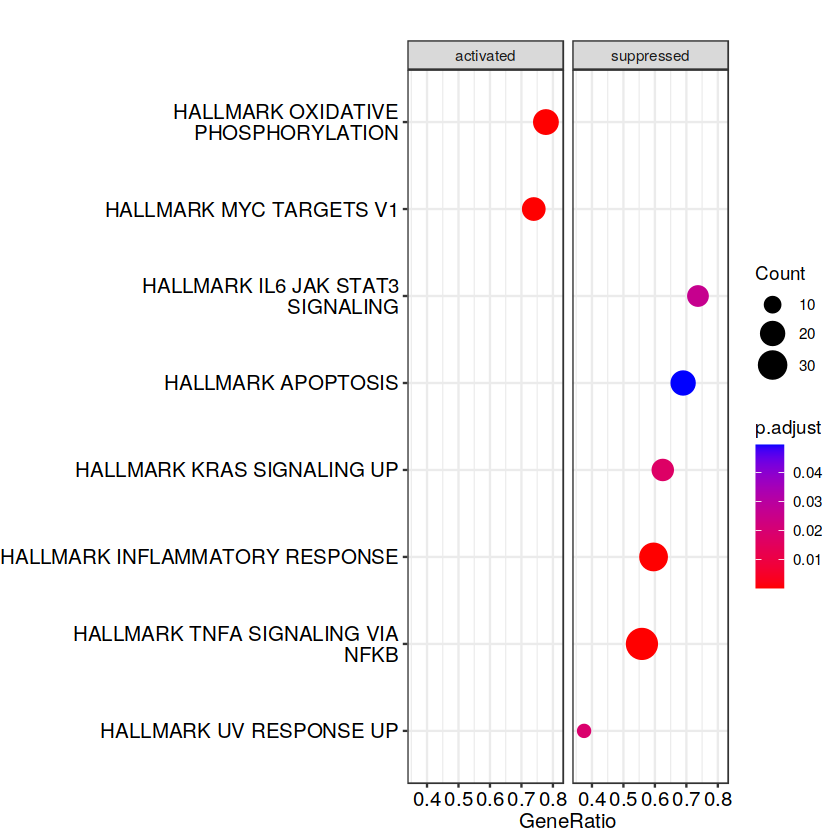

In [9]:
dotplot(gsea_results[[3]], split=".sign")  + ggplot2::xlim(0.36, 0.81) + facet_grid(~.sign)

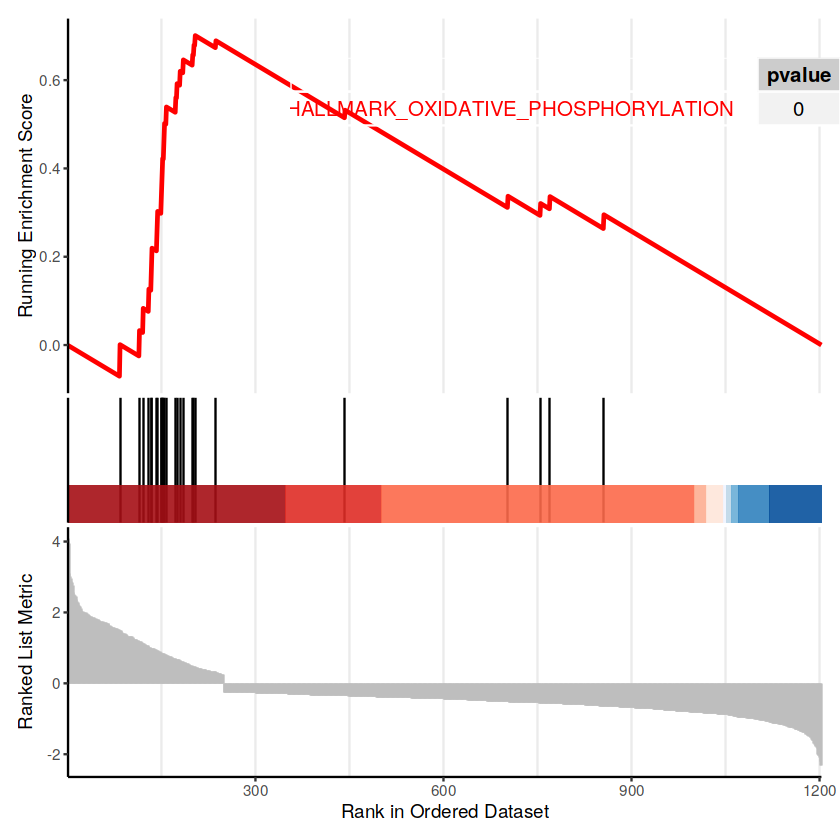

In [10]:
gseaplot2(gsea_results[[3]], 4,color="red",pvalue_table = T)

# Metabolism

## Prep files for Compass in python and shell

In [ ]:
write.table(labeled_neutrophil_merged_data@assays$RNA@data, 
            "compass/labeled_neutrophil_merged_data_1209.tsv",  
            sep="\t",  row.names=TRUE, col.names=TRUE, quote=TRUE,)

In [ ]:
write.csv(labeled_neutrophil_merged_data@meta.data, file='labeled_neutrophil_merged_metadata_1209.csv')

In [18]:
# Then run Compass in python
# compass --data labeled_neutrophil_merged_data_1209.tsv --num-processes 35 --species homo_sapiens

## Process Compass results

In [11]:
# These files are obtained from Figure1_compass_python.ipynb
compass_reactions <- read.csv("../metadata/reaction_consistencies_0313.csv", row.names = 1)
used_reaction <- read.csv('../metadata/compass_filtered_0313.csv',row.names = 1)

In [12]:
colnames(compass_reactions) <- gsub(c('\\.'), c('-'), colnames(compass_reactions))
compass_reactions_data <- labeled_neutrophil_merged_data
compass_reactions_data@assays$RNA@data <- as(as.matrix(compass_reactions), 'dgCMatrix')

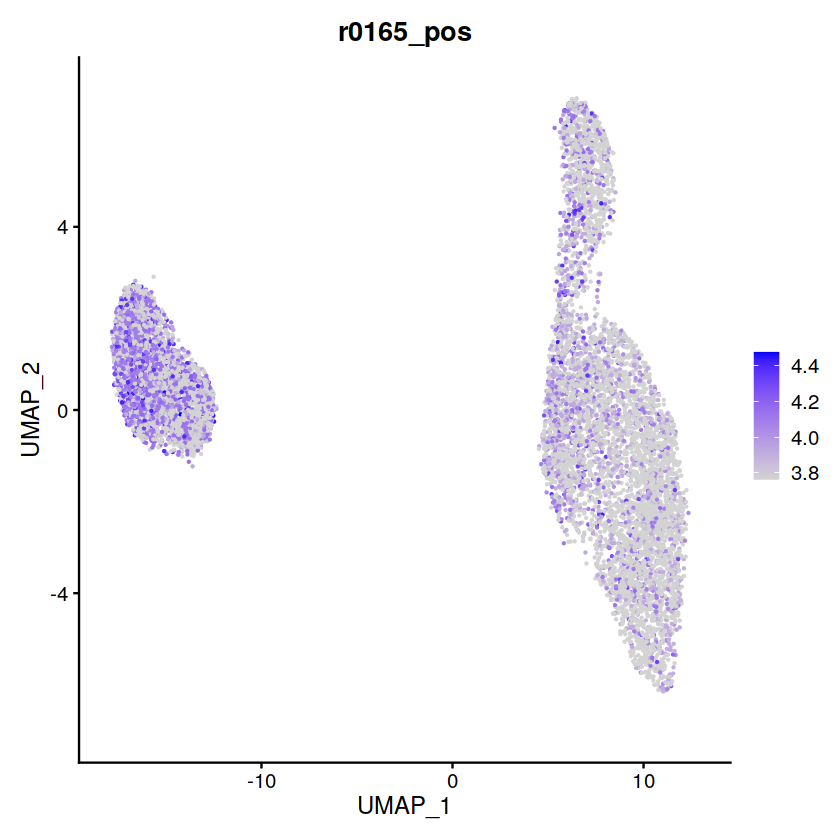

In [13]:
FeaturePlot(compass_reactions_data,'r0165_pos')

In [14]:
inflammation_genes <- read.gmt(file.path(d,gmts[3])) %>% filter(term=='HALLMARK_INFLAMMATORY_RESPONSE') %>% pull(gene)
used_inflammation_genes <- rownames(labeled_ding_harmony_combined) %>% intersect(inflammation_genes)

tmp_expr <- labeled_ding_harmony_combined[inflammation_genes,]@assays$RNA@data
tmp <- tmp_expr %>% colSums %>% as.data.frame %>% t
rownames(tmp) <- 'HALLMARK_INFLAMMATORY_RESPONSE'

Warning message:
“Removed 642 rows containing missing values (geom_point).”


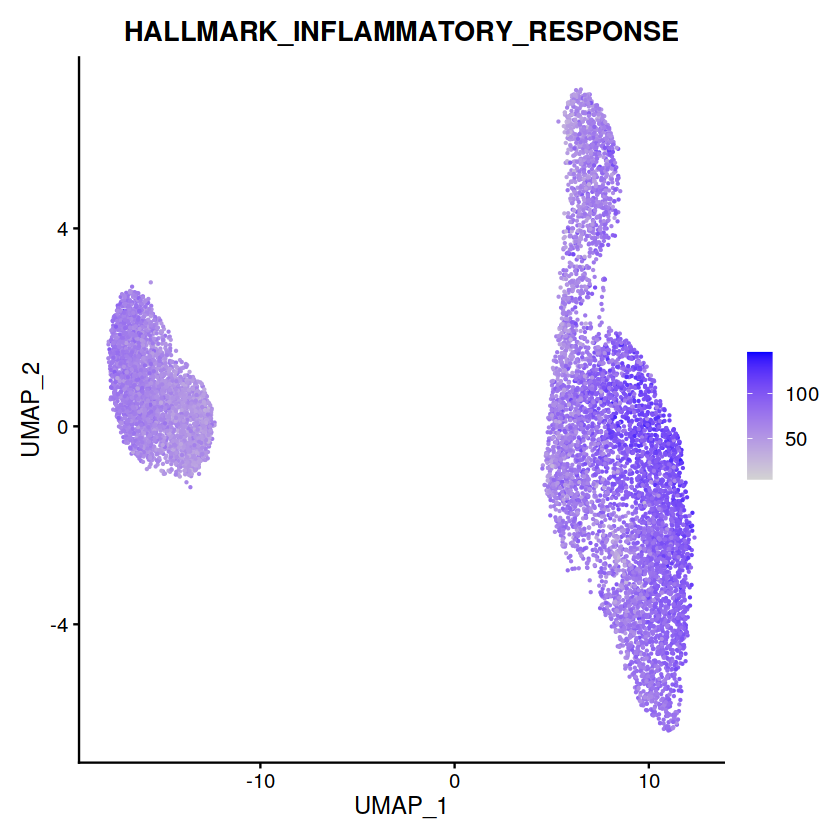

In [15]:
tmp_data <- labeled_neutrophil_merged_data
tmp_data@assays$RNA@data <- as(as.matrix(tmp), 'dgCMatrix')
FeaturePlot(tmp_data,'HALLMARK_INFLAMMATORY_RESPONSE')

In [16]:
tmp <- data.frame(labeled_neutrophil_merged_data[used_inflammation_genes]@assays$RNA@data) %>% colSums
res_tmp <- cor(t(compass_reactions), tmp, method='pearson')

In [17]:
used_reaction['sign_log_pval'] <- ifelse(used_reaction['cohens_d']>0, 1, -1) * -log10(used_reaction['adjusted_pval'])

In [18]:
corr_tmp <- sort(res_tmp[row.names(used_reaction),])
sign_log_pval_tmp <- used_reaction[names(corr_tmp),'sign_log_pval']
pval_corr_df <- data.frame(sign_log_pval=sign_log_pval_tmp, corr=corr_tmp)
pval_corr_df['reaction_name'] <- used_reaction[row.names(pval_corr_df),'reaction_name']
pval_corr_df['subsystem'] <- used_reaction[row.names(pval_corr_df),'subsystem']

In [19]:
ggplot(pval_corr_df, aes(x=sign_log_pval, y=corr)) +
geom_point() +
theme_bw() +
theme(panel.grid = element_blank()) +
geom_hline(yintercept=0, linetype='dashed') +
geom_vline(xintercept=0, linetype='dashed') +
geom_text_repel(data = pval_corr_df[c('PPAm_pos','CSm_pos','ICDHxm_pos'),], aes(label = reaction_name))

ERROR: Error in geom_text_repel(data = pval_corr_df[c("PPAm_pos", "CSm_pos", : could not find function "geom_text_repel"
